<a href="https://colab.research.google.com/github/Varshini10-02/multi_steganography/blob/main/M_P.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opencv-python matplotlib scipy


In [ ]:
!pip install pydub


In [ ]:
from pydub import AudioSegment

# Upload the mp3 file using Google Colab's upload button
from google.colab import files
uploaded = files.upload()

# Convert to wav (specifying the path for the uploaded file)
audio_path = '/content/malli_raava.mp3'  # Path for the uploaded mp3 file
audio = AudioSegment.from_mp3(audio_path)  # Change to your uploaded file name
audio = audio.set_channels(1)  # mono
audio = audio.set_frame_rate(16000)  # optional: change sample rate

# Specify path for the output wav file
output_wav_path = '/content/malli_raava.wav'

# Export the audio to wav format
audio.export(output_wav_path, format="wav")

print(f"Converted to {output_wav_path}")



Saving malli_raava.mp3 to malli_raava (3).mp3
Converted to /content/malli_raava.wav


In [ ]:
import cv2
import numpy as np

def embed_image_lsb(cover_path, secret_path, output_path):
    # Load cover image (color) and secret image (grayscale)
    cover = cv2.imread(cover_path)
    secret = cv2.imread(secret_path, cv2.IMREAD_GRAYSCALE)

    # Resize secret image to match cover image
    secret_resized = cv2.resize(secret, (cover.shape[1], cover.shape[0]))

    # Threshold secret to binary (0 or 1)
    _, binary_secret = cv2.threshold(secret_resized, 127, 1, cv2.THRESH_BINARY)

    # Embed binary secret into the blue channel LSB of cover
    stego = cover.copy()
    stego[:, :, 0] &= 0b11111110  # Clear LSB
    stego[:, :, 0] |= binary_secret  # Set LSB with secret

    # Save the stego image
    cv2.imwrite(output_path, stego)
    print(f"✅ Secret image embedded (invisible). Saved as {output_path}")

# Run embedding
embed_image_lsb(
    '/content/cover.jpg',              # Dog image (cover)
    '/content/message_img.jpg',        # Butterfly image (secret)
    '/content/stego_invisible.png'     # Output stego image
)


✅ Secret image embedded (invisible). Saved as /content/stego_invisible.png


In [ ]:
import cv2
import numpy as np

def text_to_binary(text):
    return ''.join([format(ord(char), '08b') for char in text])

def embed_text(cover_path, secret_text, output_path):
    # Load cover image
    img = cv2.imread(cover_path)
    if img is None:
        raise ValueError("Image not found or invalid path.")

    binary_secret = text_to_binary(secret_text + "#####")  # '#####' marks end of message
    data_index = 0
    total_bits = len(binary_secret)

    stego_img = img.copy()
    rows, cols, _ = img.shape

    for row in range(rows):
        for col in range(cols):
            for channel in range(3):  # B, G, R
                if data_index < total_bits:
                    pixel_bin = format(stego_img[row, col, channel], '08b')
                    pixel_bin = pixel_bin[:-1] + binary_secret[data_index]
                    stego_img[row, col, channel] = int(pixel_bin, 2)
                    data_index += 1

    if data_index < total_bits:
        raise ValueError("Cover image not large enough to hold all data!")

    cv2.imwrite(output_path, stego_img)
    print(f"Secret text embedded and saved as {output_path}")

# Usage
embed_text('/content/cover.jpg', 'hello', '/content/stego_image.png')


Secret text embedded and saved as /content/stego_image.png


In [ ]:
import numpy as np
import cv2
import os
from scipy.io import wavfile
import os

# Create folder if it doesn't exist
os.makedirs("/content/stego_images", exist_ok=True)


def audio_to_chunks(audio_path, chunk_size=65536):
    rate, data = wavfile.read(audio_path)
    data = data[:rate*30]  # trim to 30 sec
    flat = data.flatten()
    chunks = [flat[i:i+chunk_size] for i in range(0, len(flat), chunk_size)]
    return chunks, rate

def encode_audio_chunk_to_image(chunk, shape):
    chunk = np.pad(chunk, (0, shape[0]*shape[1] - len(chunk)), 'constant')
    chunk = np.int16(chunk)
    reshaped = chunk.reshape(shape)
    return np.uint8((reshaped >> 8) & 0xFF)

audio_path = "/content/malli_raava.wav"
audio_chunks, audio_rate = audio_to_chunks(audio_path)

# Create folder to save images
os.makedirs("/content/stego_images", exist_ok=True)

# Now encode and save images
for idx, chunk in enumerate(audio_chunks):
    img = encode_audio_chunk_to_image(chunk, (256, 256))
    cv2.imwrite(f"/content/stego_images/audio_{idx}.png", img)

print("✅ Encoding complete. All images saved in 'stego_images' folder.")


✅ Encoding complete. All images saved in 'stego_images' folder.


In [ ]:
import cv2
import numpy as np
import os
from scipy.io import wavfile
from pydub import AudioSegment

# -----------------------------------
# TEXT EMBEDDING FUNCTIONS
# -----------------------------------
def text_to_binary(text):
    return ''.join([format(ord(char), '08b') for char in text])

def embed_text(cover_img, secret_text):
    binary_secret = text_to_binary(secret_text + "#####")  # '#####' marks end of message
    data_index = 0
    total_bits = len(binary_secret)

    stego_img = cover_img.copy()
    rows, cols, _ = stego_img.shape

    for row in range(rows):
        for col in range(cols):
            for channel in range(3):  # B, G, R
                if data_index < total_bits:
                    pixel_bin = format(stego_img[row, col, channel], '08b')
                    pixel_bin = pixel_bin[:-1] + binary_secret[data_index]  # Embed 1 bit
                    stego_img[row, col, channel] = int(pixel_bin, 2)
                    data_index += 1

    if data_index < total_bits:
        raise ValueError("Cover image not large enough to hold all text!")

    print("✅ Secret text embedded.")
    return stego_img

# -----------------------------------
# IMAGE EMBEDDING FUNCTIONS
# -----------------------------------
def embed_image(cover_img, secret_img_path):
    secret = cv2.imread(secret_img_path, cv2.IMREAD_GRAYSCALE)
    secret_resized = cv2.resize(secret, (cover_img.shape[1], cover_img.shape[0]))

    _, binary_secret = cv2.threshold(secret_resized, 127, 1, cv2.THRESH_BINARY)

    stego_img = cover_img.copy()
    stego_img[:, :, 0] &= 0b11111110  # Clear LSB of Blue channel
    stego_img[:, :, 0] |= binary_secret  # Insert secret

    print("✅ Secret image embedded.")
    return stego_img

# -----------------------------------
# AUDIO EMBEDDING FUNCTIONS
# -----------------------------------
def convert_mp3_to_wav(mp3_path, wav_path):
    audio = AudioSegment.from_mp3(mp3_path)
    audio.export(wav_path, format="wav")
    print("✅ MP3 converted to WAV.")

def audio_to_chunks(audio_path, chunk_size=65536):
    rate, data = wavfile.read(audio_path)
    data = data[:rate*30]  # Trim to 30 sec
    flat = data.flatten()
    chunks = [flat[i:i+chunk_size] for i in range(0, len(flat), chunk_size)]
    return chunks, rate

def encode_audio_chunk_to_image(chunk, shape=(512, 512)):
    chunk = np.pad(chunk, (0, shape[0]*shape[1] - len(chunk)), 'constant')
    chunk = np.int16(chunk)
    reshaped = chunk.reshape(shape)
    return np.uint8((reshaped >> 8) & 0xFF)

def embed_audio(audio_path, output_folder="/content/stego_images_1"):
    audio_chunks, audio_rate = audio_to_chunks(audio_path, chunk_size=512*512)
    os.makedirs(output_folder, exist_ok=True)

    for idx, chunk in enumerate(audio_chunks):
        img = encode_audio_chunk_to_image(chunk, shape=(512, 512))
        cv2.imwrite(os.path.join(output_folder, f"audio_{idx}.png"), img)

    print(f"✅ Audio embedded into {len(audio_chunks)} image(s) with 512×512 size.")

# -----------------------------------
# MAIN DRIVER FUNCTION
# -----------------------------------
def multimodal_steganography(cover_path, secret_text, secret_img_path, audio_path):
    # Load cover
    cover_img = cv2.imread(cover_path)
    if cover_img is None:
        raise ValueError("Cover image not found.")

    # Step 1: Embed text into cover
    stego_text_img = embed_text(cover_img, secret_text)

    # Step 2: Embed image into stego_text_img
    stego_text_image_img = embed_image(stego_text_img, secret_img_path)

    # Save the intermediate stego image
    final_stego_path = "/content/final_stego_image.png"
    cv2.imwrite(final_stego_path, stego_text_image_img)
    print(f"✅ Final stego image (text+image) saved at {final_stego_path}")

    # Step 3: Convert MP3 to WAV if needed
    wav_audio_path = "/content/secret_audio.wav"
    if audio_path.endswith('.mp3'):
        convert_mp3_to_wav(audio_path, wav_audio_path)
    else:
        wav_audio_path = audio_path  # Already a wav

    # Step 4: Embed audio into separate images
    embed_audio(wav_audio_path, output_folder="/content/stego_images_1")

    print("🎉 Multimodal steganography completed successfully!")

# --------------------------------------------------
# 📢 Usage Example
# --------------------------------------------------
multimodal_steganography(
    cover_path="/content/cover.jpg",
    secret_text="hello",
    secret_img_path="/content/message_img.jpg",
    audio_path="/content/malli_raava.mp3"
)


✅ Secret text embedded.
✅ Secret image embedded.
✅ Final stego image (text+image) saved at /content/final_stego_image.png
✅ MP3 converted to WAV.
✅ Audio embedded into 11 image(s) with 512×512 size.
🎉 Multimodal steganography completed successfully!


In [ ]:
from google.colab.patches import cv2_imshow
from IPython.display import Audio, display


🖼️ Input Cover Image:


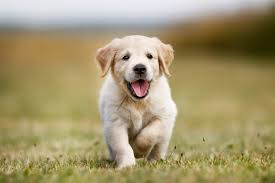


🔤 Secret Text to Embed:
hello
✅ Secret text embedded.

🖼️ Secret Image to Embed:


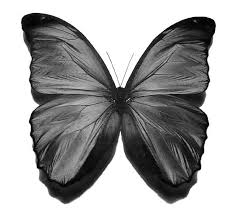

✅ Secret image embedded.
✅ Final stego image (text+image) saved at /content/final_stego_image.png
✅ MP3 converted to WAV.
✅ Audio embedded into 11 image(s) with 512×512 size.

🔊 Playing Original Audio:


🎉 Multimodal steganography completed successfully!


In [ ]:
def multimodal_steganography(cover_path, secret_text, secret_img_path, audio_path):
    # Load cover
    cover_img = cv2.imread(cover_path)
    if cover_img is None:
        raise ValueError("Cover image not found.")

    # Display Cover Image
    print("🖼️ Input Cover Image:")
    cv2_imshow(cover_img)

    # Display Secret Text
    print("\n🔤 Secret Text to Embed:")
    print(secret_text)

    # Step 1: Embed text into cover
    stego_text_img = embed_text(cover_img, secret_text)

    # Step 2: Embed image into stego_text_img
    secret_img = cv2.imread(secret_img_path, cv2.IMREAD_GRAYSCALE)
    if secret_img is None:
        raise ValueError("Secret image not found.")

    print("\n🖼️ Secret Image to Embed:")
    cv2_imshow(secret_img)

    stego_text_image_img = embed_image(stego_text_img, secret_img_path)

    # Save the intermediate stego image
    final_stego_path = "/content/final_stego_image.png"
    cv2.imwrite(final_stego_path, stego_text_image_img)
    print(f"✅ Final stego image (text+image) saved at {final_stego_path}")

    # Step 3: Convert MP3 to WAV if needed
    wav_audio_path = "/content/secret_audio.wav"
    if audio_path.endswith('.mp3'):
        convert_mp3_to_wav(audio_path, wav_audio_path)
    else:
        wav_audio_path = audio_path  # Already a wav

    # Step 4: Embed audio into separate images
    embed_audio(wav_audio_path, output_folder="/content/stego_images_1")

    # Display input audio
    print("\n🔊 Playing Original Audio:")
    display(Audio(wav_audio_path))

    print("🎉 Multimodal steganography completed successfully!")
multimodal_steganography(
    cover_path="/content/cover.jpg",
    secret_text="hello",
    secret_img_path="/content/message_img.jpg",
    audio_path="/content/malli_raava.mp3"
)


Extracted secret message: hello
🔍 Extracted Text: hello
✅ Secret image extracted.
🖼️ Secret image saved at extracted_secret_image.png
✅ Secret audio reconstructed at: secret_audio_2.wav
🎧 Duration: 30.00 seconds
🎉 Multimodal steganography decoding completed!

🔑 Decoding Results:
Extracted Text:  hello
Extracted Image: Saved as 'extracted_secret_image.png'
Reconstructed Audio: Saved as 'secret_audio_2.wav'


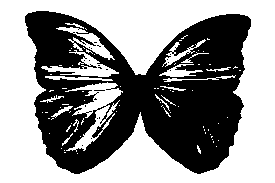

In [ ]:
import cv2
import numpy as np
import os
from scipy.io import wavfile
from google.colab.patches import cv2_imshow  # Import cv2_imshow for Colab

# -----------------------------------
# TEXT DECODING FUNCTIONS
# -----------------------------------

# Extract LSB binary data from image
# Extract LSB binary data from image
def binary_to_text(binary_data):
    # Split binary data into chunks of 8 bits and convert to characters
    text = ''.join([chr(int(binary_data[i:i+8], 2)) for i in range(0, len(binary_data), 8)])
    return text

def extract_text(stego_image_path):
    # Load the stego image
    img = cv2.imread("/content/stego_image.png")
    if img is None:
        raise ValueError("Image not found or invalid path.")

    rows, cols, _ = img.shape
    binary_data = ''

    for row in range(rows):
        for col in range(cols):
            for channel in range(3):  # B, G, R
                # Extract the least significant bit (LSB) of each pixel
                pixel_bin = format(img[row, col, channel], '08b')
                binary_data += pixel_bin[-1]  # LSB of the channel

    # Check for the '#####' end marker in the binary data
    end_marker = '0010010000100100001001000010010000100100'  # '#####' in binary
    end_marker_pos = binary_data.find(end_marker)

    # Extract the binary data before the end marker
    message_binary = binary_data[:end_marker_pos]

    # Convert binary data to text
    secret_message = binary_to_text(message_binary)

    # Remove '#####' from the message (if it appears at the end)
    secret_message = secret_message.split("#####")[0]  # Keep everything before '#####'

    return secret_message

# Usage
secret_message = extract_text('/content/stego_image.png')
print(f"Extracted secret message: {secret_message}")


# -----------------------------------
# IMAGE DECODING FUNCTION
# -----------------------------------
def extract_image(stego_img):
    extracted_bits = stego_img[:, :, 0] & 1  # LSB of Blue channel
    extracted_image = np.uint8(extracted_bits * 255)
    print("✅ Secret image extracted.")
    return extracted_image

# -----------------------------------
# AUDIO DECODING FUNCTION
# -----------------------------------
def decode_audio_images(image_folder, output_wav_path, sample_rate=44100, duration_seconds=30):
    total_samples = sample_rate * duration_seconds
    image_files = sorted([f for f in os.listdir(image_folder) if f.endswith('.png')])

    audio_data = []

    for file in image_files:
        img_path = os.path.join(image_folder, file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        # Assuming 8-bit values stored from 16-bit audio
        flat = img.flatten()

        # Append all pixel values directly as 8-bit data
        audio_data.extend(flat)

    # Convert 8-bit stream to 16-bit samples (2 bytes per sample: little-endian)
    byte_data = np.array(audio_data[:total_samples * 2], dtype=np.uint8)
    audio_16bit = np.frombuffer(byte_data.tobytes(), dtype=np.int16)

    # Trim or pad to exactly 30 seconds
    if len(audio_16bit) < total_samples:
        audio_16bit = np.pad(audio_16bit, (0, total_samples - len(audio_16bit)), 'constant')
    else:
        audio_16bit = audio_16bit[:total_samples]

    # Write WAV file
    wavfile.write(output_wav_path, sample_rate, audio_16bit)
    print(f"✅ Secret audio reconstructed at: {output_wav_path}")
    print(f"🎧 Duration: {len(audio_16bit) / sample_rate:.2f} seconds")


# -----------------------------------
# MAIN DRIVER FUNCTION
# -----------------------------------
def multimodal_steganography_decode(stego_image_path, audio_images_folder):
    # Load stego image
    stego_img = cv2.imread(stego_image_path)
    if stego_img is None:
        raise ValueError("Stego image not found!")

    # Step 1: Extract secret text
    secret_text = extract_text(stego_img)
    print(f"🔍 Extracted Text: {secret_text}")

    # Step 2: Extract secret image
    secret_image = extract_image(stego_img)
    extracted_img_path = "extracted_secret_image.png"
    cv2.imwrite(extracted_img_path, secret_image)
    print(f"🖼️ Secret image saved at {extracted_img_path}")

    # Step 3: Reconstruct secret audio
    reconstructed_audio_path = "secret_audio_2.wav"
    decode_audio_images(audio_images_folder, reconstructed_audio_path)

    print("🎉 Multimodal steganography decoding completed!")

    # Displaying the extracted text, image, and audio
    print("\n🔑 Decoding Results:")
    print("Extracted Text: ", secret_text)  # Print out the decoded text message
    print("Extracted Image: Saved as 'extracted_secret_image.png'")  # File name for the secret image
    print("Reconstructed Audio: Saved as 'secret_audio_2.wav'")  # Audio path

    # Display the extracted image in Colab
    cv2_imshow(secret_image)

# --------------------------------------------------
# 📢 Usage Example
# --------------------------------------------------
multimodal_steganography_decode(
    stego_image_path="/content/final_stego_image.png",        # Replace with your image path
    audio_images_folder="/content/stego_images_1"             # Replace with your folder path
)
